In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree


In [2]:
#download relevant market data...out = nex day close
def market_sim(symbol, start, end):
    
    op = get_pricing(symbol, start_date = start, end_date = end, fields = 'close_price').pct_change()[1:-1]
    cls = get_pricing(symbol, start_date = start, end_date = end, fields = 'open_price').pct_change()[1:-1]
    high = get_pricing(symbol, start_date = start, end_date = end, fields = 'high').pct_change()[1:-1]
    low = get_pricing(symbol, start_date = start, end_date = end, fields = 'low').pct_change()[1:-1]
    out = get_pricing(symbol, start_date = start, end_date = end, fields = 'close_price').pct_change()[2:]
    
    temp = {'open': op,
           'close': cls,
           'high': high,
           'low':low}
     
    data = pd.DataFrame(temp).dropna()
    
    return data,out
    

In [3]:
data, out = market_sim('aapl','2003-01-01','2014-01-01')

In [4]:
print(data.head())
out.head()

                              close      high       low      open
2003-01-03 00:00:00+00:00  0.030683  0.000693  0.016720  0.007402
2003-01-06 00:00:00+00:00  0.015514  0.030202  0.019847 -0.001941
2003-01-07 00:00:00+00:00 -0.015965 -0.024744 -0.027523 -0.004723
2003-01-08 00:00:00+00:00 -0.014126 -0.019305 -0.002144 -0.018283
2003-01-09 00:00:00+00:00  0.002695  0.014201  0.004154  0.009667


2003-01-06 00:00:00+00:00   -0.001941
2003-01-07 00:00:00+00:00   -0.004723
2003-01-08 00:00:00+00:00   -0.018283
2003-01-09 00:00:00+00:00    0.009667
2003-01-10 00:00:00+00:00    0.003379
Freq: C, Name: Equity(24 [AAPL]), dtype: float64

In [5]:
#digitalise output for training and testing
def digitalise_output(out):

    for i in range(len(out)):
        if out[i] > 0:
            out[i] = 1
        elif out[i] < 0:
            out[i] = 0
        elif out[i] == 0:
            out[i] = 0
        else:
            print('we have a problem')

    return(out)
        
print('out')      
out = digitalise_output(out)



out


In [6]:
#train algo
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data, out)

In [7]:
#generate test data, and test output(crossvf)

test, crossvf = market_sim('aapl', '2014-01-01', '2017-06-01')
mul = crossvf*1.0

In [8]:
#generate predictions
result = clf.predict(test)
len(crossvf) == len(result)


True

In [9]:
#digitalise test output for matching with predictions
dcrossv = digitalise_output(crossvf)
#print(pd.DataFrame({'predicted_results':result, 'actual_results':crossv}))

In [10]:
#fcn for scoring algo
def scorer(result, crossv):
    score = np.zeros((len(crossv)))
    for i in range(len(crossv)):
        if result[i] == dcrossv[i]:
            score[i] += 1
        
        
    print(np.sum(score))        
    pct_score = 100 * float((np.sum(score)) / (len(crossv)))
    return pct_score, score


In [11]:
#score algo
pct_score, score = scorer(result, crossvf)
print(pct_score)

454.0
52.9137529138


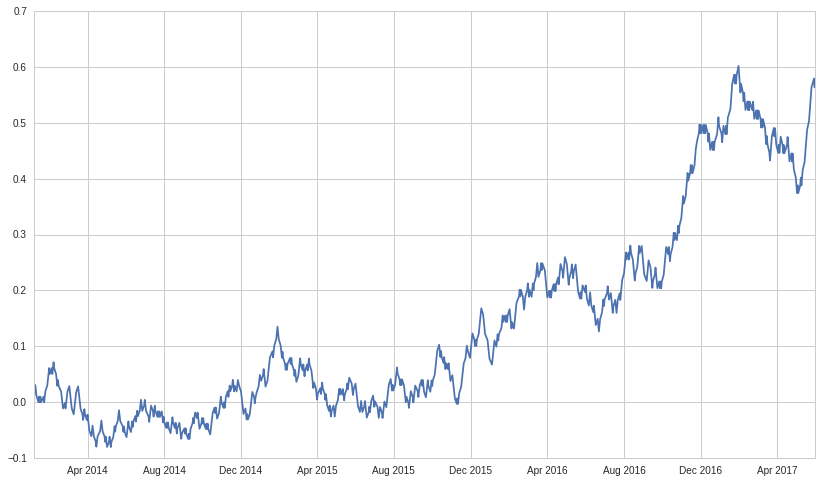

In [12]:
#generate and plot simulated results...assuming each day net change is 1%
score[score == 0] = -1
pct_score = score/100
#print(pct_score)
plt.plot(crossvf.index, np.cumprod(pct_score+1)-1)

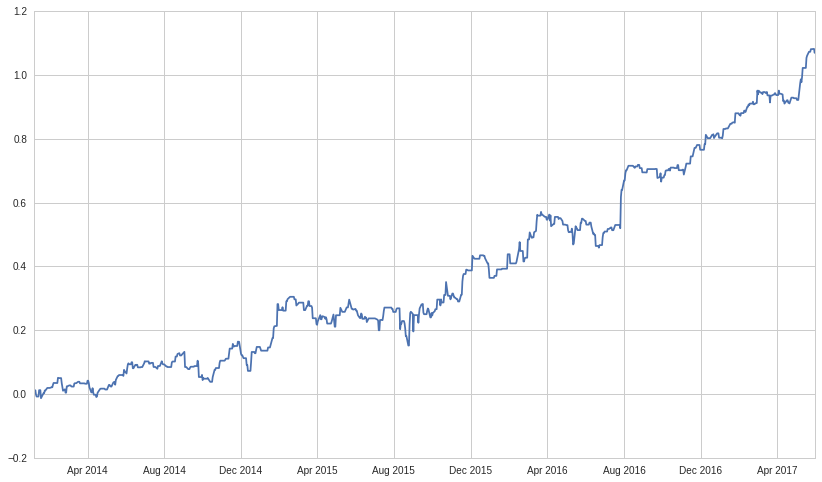

In [13]:
#generate and plot actual results
returns = np.multiply(result, mul)
cum_returns = np.cumprod(1+returns)-1
plt.plot(cum_returns)

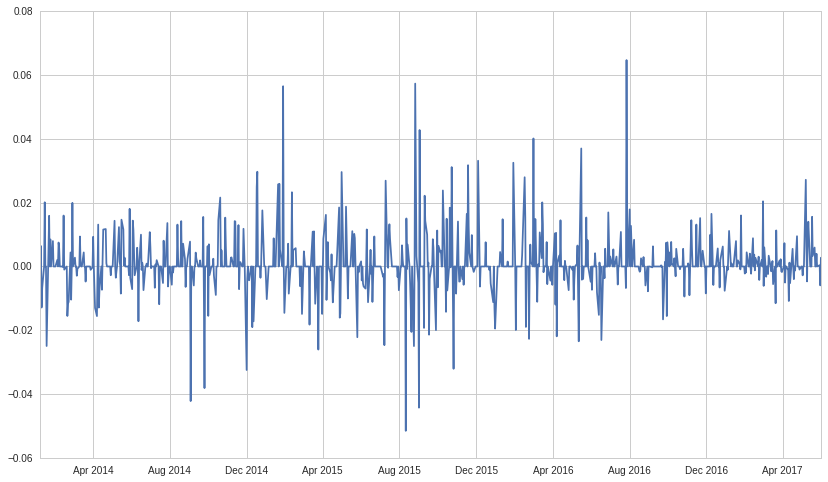

In [14]:
plt.plot(returns)

In [15]:
(returns.mean()/ returns.std()) * np.sqrt(252)

1.5242734687575341

In [16]:
#next steps: run for multiple stocks, etfs, vary time lag, add more features